## 1. Library Imports
Importing all necessary libraries for data analysis, visualization, and machine learning.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import ttest_ind, pearsonr

## 2. Data Reading and Cleaning
Read the Excel file and prepare data for analysis. Ensure types are correct and transform necessary columns.

In [55]:
df = pd.read_excel("dsa210_dataset.xlsx")
df.columns = ['Date', 'Game', 'Turkish Support', 'Average Players','Positive Reviews', 'Negative Reviews' , 'Followers']
df['Date'] = pd.to_datetime(df['Date'])
#df['Turkish Support'] = df['Turkish Support'].map({'Yes': 1, 'No': 0})
df['Negative Reviews'] = df['Negative Reviews'].abs()
print("Missing values:\n", df.isnull().sum())

Missing values:
 Date                0
Game                0
Turkish Support     0
Average Players     0
Positive Reviews    0
Negative Reviews    0
Followers           0
dtype: int64


## 3. Histogram
Show distribution of average player count.

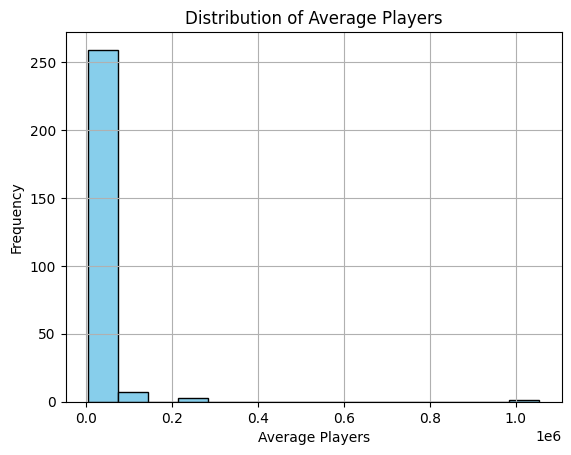

In [56]:
plt.hist(df['Average Players'], bins=15, color='skyblue', edgecolor='black')
plt.title("Distribution of Average Players")
plt.xlabel("Average Players")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 4. Boxplot
Compare average player counts by Turkish support using a boxplot.

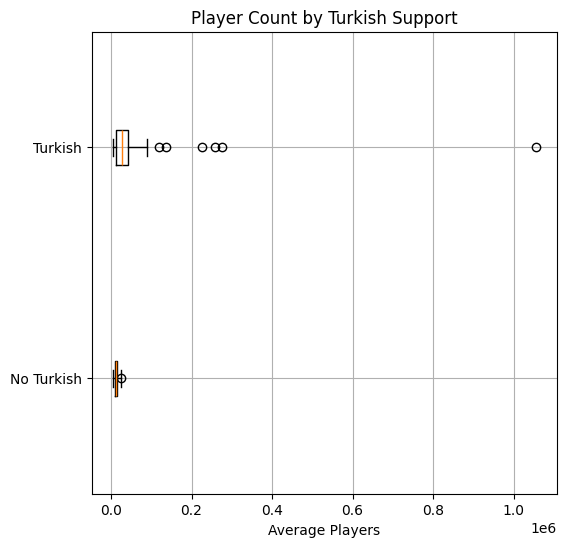

In [57]:
turkish = df[df['Turkish Support'] == 1]['Average Players'].dropna()
non_turkish = df[df['Turkish Support'] == 0]['Average Players'].dropna()

if len(turkish) > 0 and len(non_turkish) > 0:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.boxplot([non_turkish, turkish], vert=False, tick_labels=['No Turkish', 'Turkish'])
    ax.set_xlabel("Average Players")
    ax.set_title("Player Count by Turkish Support")
    ax.grid(True)
    plt.show()
else:
    print("Either Turkish or Non-Turkish group has no data.")

## 5. Bar Chart
Display the mean average player count for each group.

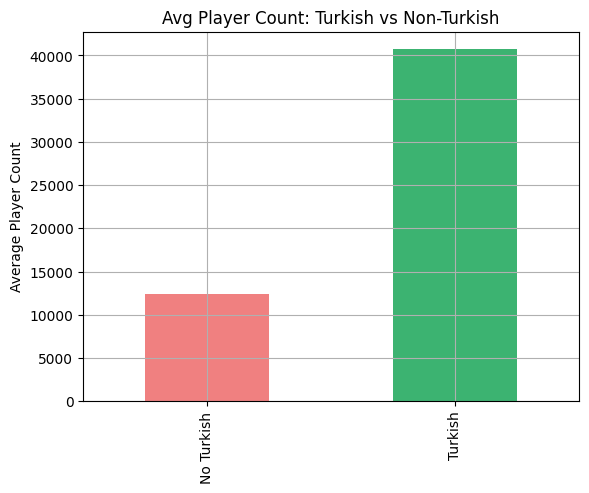

In [58]:
means = df.groupby('Turkish Support')['Average Players'].mean()
labels = ['No Turkish', 'Turkish']
colors = ['lightcoral', 'mediumseagreen']
means.index = labels
means.plot(kind='bar', color=colors)
plt.ylabel("Average Player Count")
plt.title("Avg Player Count: Turkish vs Non-Turkish")
plt.grid(True)
plt.show()

## 6. Correlation Analysis
Evaluate the correlation between Turkish support and average players.

In [59]:
corr, p_value = pearsonr(df['Turkish Support'], df['Average Players'])
print(f"Pearson correlation: {corr:.2f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("The p-value is less than 0.05. We reject the null hypothesis.")
    print("There is a statistically significant relationship between Turkish language support and average player counts.")
else:
    print("The p-value is greater than or equal to 0.05. We fail to reject the null hypothesis.")
    print("There is no statistically significant relationship between Turkish support and player count.")

Pearson correlation: 0.20, P-value: 0.0010
The p-value is less than 0.05. We reject the null hypothesis.
There is a statistically significant relationship between Turkish language support and average player counts.


## 7. Hypothesis Testing
Test whether Turkish support leads to significantly different player counts.

In [60]:
t_stat, p_val = ttest_ind(turkish, non_turkish, equal_var=False)
print("\nT-statistic:", round(t_stat, 2))
print("P-value:", round(p_val, 6))
if p_val < 0.05:
    print("We reject Null Hypothesis. Games with Turkish support receive significantly higher player counts.")
else:
    print("We fail to reject Null Hypothesis. No significant difference in player counts based on language support.")


T-statistic: 4.06
P-value: 7.6e-05
We reject Null Hypothesis. Games with Turkish support receive significantly higher player counts.


## 8. Group Averages
Mean player counts for both groups.

In [61]:
print("Turkish Support: ~", round(turkish.mean(), 2))
print("No Turkish Support: ~", round(non_turkish.mean(), 2))

Turkish Support: ~ 40702.66
No Turkish Support: ~ 12450.69


## 9. Linear Regression
Fit and visualize a linear regression model.

Intercept (β₀): -10437.39
Slope (β₁): 0.06


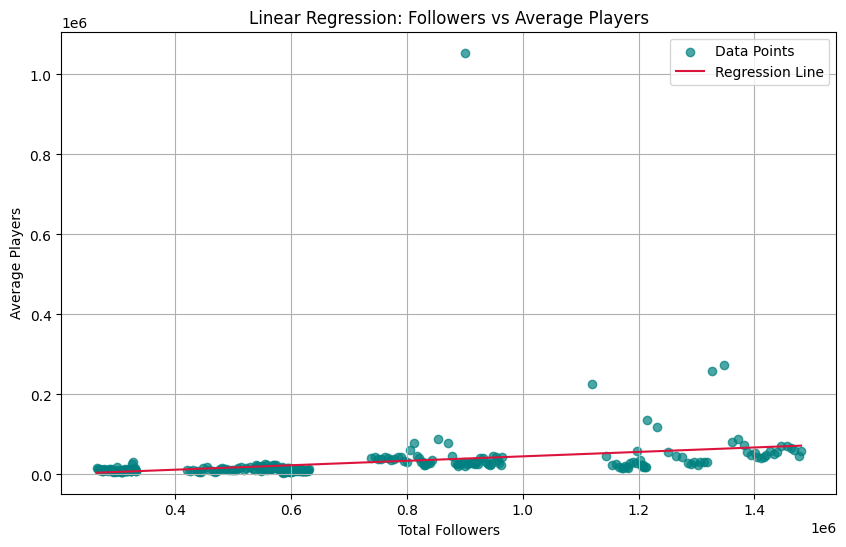

In [62]:
X = df[['Followers']]
y = df['Average Players'].values

model = LinearRegression()
model.fit(X, y)

print(f"Intercept (β₀): {model.intercept_:.2f}")
print(f"Slope (β₁): {model.coef_[0]:.2f}")


x_range = np.linspace(X['Followers'].min(), X['Followers'].max(), 100).reshape(-1, 1)
x_range_df = pd.DataFrame(x_range, columns=['Followers'])  

y_pred = model.predict(x_range_df)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, color='teal', label='Data Points')
plt.plot(x_range, y_pred, color='crimson', label='Regression Line')
plt.title("Linear Regression: Followers vs Average Players")
plt.xlabel("Total Followers")
plt.ylabel("Average Players")
plt.legend()
plt.grid(True)
plt.show()

## 10. Machine Learning Models
Train and evaluate ML models to predict player counts.

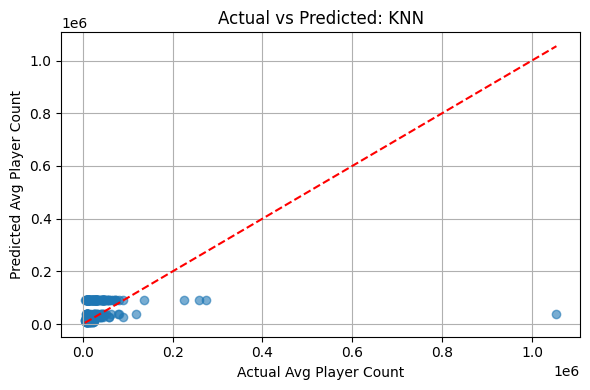

MAE (Mean Absolute Error): 32159.83
RMSE (Root Mean Squared Error): 75138.05



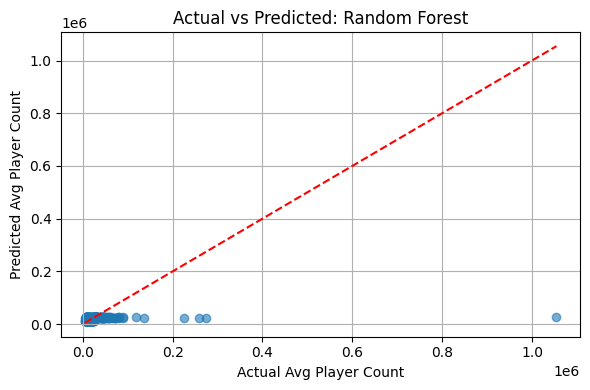

MAE (Mean Absolute Error): 17062.94
RMSE (Root Mean Squared Error): 69341.77



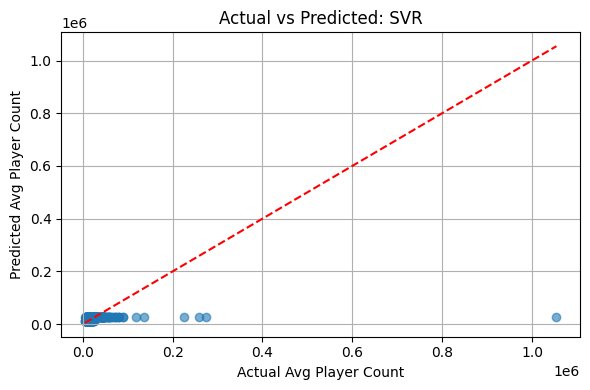

MAE (Mean Absolute Error): 17028.37
RMSE (Root Mean Squared Error): 69192.49



In [63]:
df['Log_Average_Players'] = np.log1p(df['Average Players'])

X = df[['Turkish Support']]
y_log = df['Log_Average_Players']
y_actual = df['Average Players']

cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "KNN": KNeighborsRegressor(n_neighbors=3),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR()
}

results = {}
for name, model in models.items():
    y_pred_log = cross_val_predict(model, X, y_log, cv=cv)
    y_pred = np.expm1(y_pred_log)  # convert back from log scale

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2 = r2_score(y_actual, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    plt.figure(figsize=(6, 4))
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
    plt.title(f'Actual vs Predicted: {name}')
    plt.xlabel('Actual Avg Player Count')
    plt.ylabel('Predicted Avg Player Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print()

## 11. Model Performance Table
Comparison of performance metrics for each ML model.

In [64]:
results_df = pd.DataFrame(results).T
print("\nModel Performance Table:")
print(results_df)


Model Performance Table:
                        MAE          RMSE        R2
KNN            32159.830922  75138.053851 -0.162987
Random Forest  17062.942405  69341.771408  0.009522
SVR            17028.367411  69192.487701  0.013782


## 12. Confusion Matrix
Binned confusion matrices of predicted player count categories.

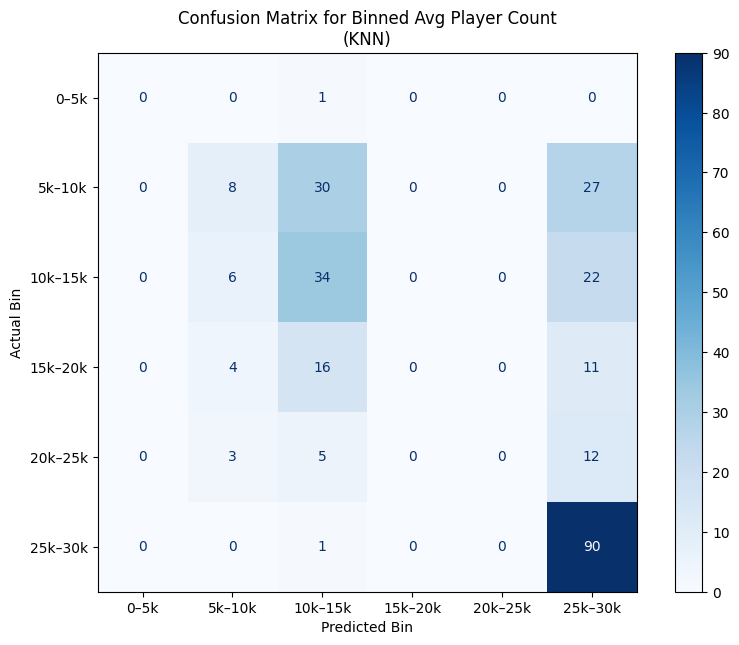

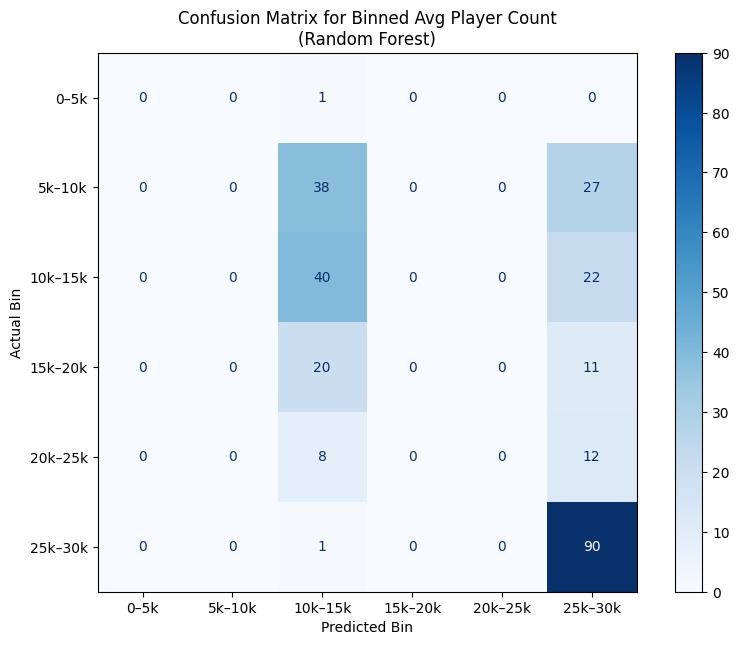

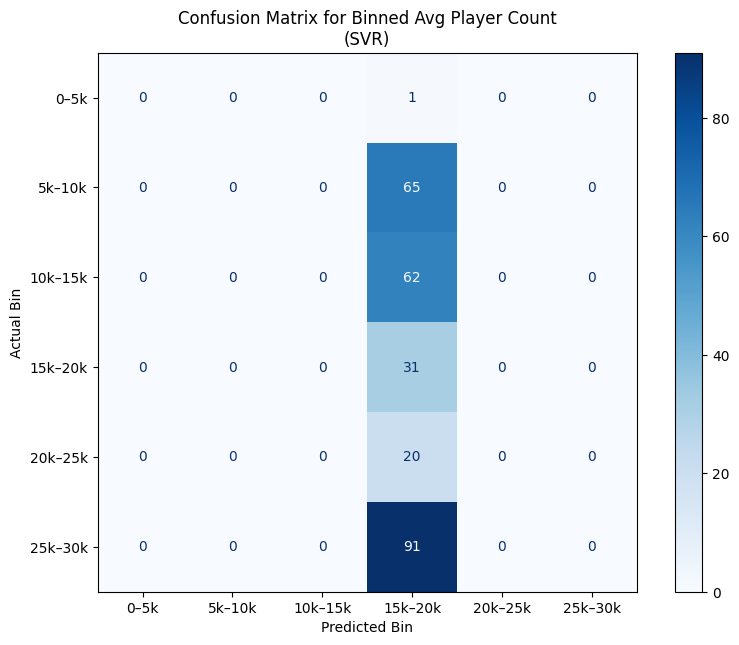

In [65]:
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000]
labels = ['0–5k', '5k–10k', '10k–15k', '15k–20k', '20k–25k', '25k–30k']
for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=cv)
    y_clipped = np.clip(y, bins[0], bins[-1] - 1)
    y_pred_clipped = np.clip(y_pred, bins[0], bins[-1] - 1)
    y_bins = pd.cut(y_clipped, bins=bins, labels=labels)
    y_pred_bins = pd.cut(y_pred_clipped, bins=bins, labels=labels)
    y_codes = pd.Categorical(y_bins, categories=labels).codes
    y_pred_codes = pd.Categorical(y_pred_bins, categories=labels).codes
    cm = confusion_matrix(y_codes, y_pred_codes, labels=range(len(labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(10, 7))
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title(f"Confusion Matrix for Binned Avg Player Count\n({name})")
    plt.xlabel("Predicted Bin")
    plt.ylabel("Actual Bin")
    plt.grid(False)
    plt.show()